In [1]:
#Importing Simulation Snapshot & Units Conversion Factors

In [3]:
import sys
sys.path.insert(0, '/export/home/extragal/lucia.armillotta/pyathena')
import pyathena as pa

from astropy import units
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py

basedir = '/export/home/extragal/lucia.armillotta/TIGRESS/R8'
output_dir = '/export/home/extragal/francesco.chititegli/TIGRESS_1/'
snapshot_number = 0

s = pa.LoadSim(basedir, verbose=False)
ds = s.load_vtk(num=s.nums[snapshot_number])
u = s.u

[FindFiles-WARNING] Vtk file size is not unique.
[FindFiles-WARNING] vtk num: 0, size [MB]: 8834
[FindFiles-WARNING] vtk num: 1, size [MB]: 8834
[FindFiles-WARNING] vtk num: 2, size [MB]: 8834
[FindFiles-WARNING] vtk num: 3, size [MB]: 8834
[FindFiles-WARNING] vtk num: 4, size [MB]: 8834
[FindFiles-WARNING] vtk num: 5, size [MB]: 8834
[FindFiles-WARNING] vtk num: 6, size [MB]: 8834
[FindFiles-WARNING] vtk num: 7, size [MB]: 8834
[FindFiles-WARNING] vtk num: 8, size [MB]: 8834
[FindFiles-WARNING] rst files in out_fmt but not found.
/export/home/extragal/lucia.armillotta/.conda/envs/pyathena/lib/python3.11/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [4]:
# Lenghts are already in pc, Velocities are already in km/s, Temperatures seem to already be in K
time_cf = (u.time).to(units.Gyr).value
mass_cf = (s.u.mass).to(units.M_sun).value
density_cf = (s.u.density).to(units.M_sun / units.pc**3).value
number_density_cf = (units.cm**-3).to(units.pc**-3)
solar_metallicity = 0.0134

In [4]:
print(s.basedir)
print(s.basename)
print(s.problem_id)
Nx = ds.domain['Nx']
dx = ds.domain['dx']
volume = dx[0] * dx[1] * dx[2]
s.domain

/export/home/extragal/lucia.armillotta/TIGRESS/R8
R8
R8_4pc_NCR


{'all_grid_equal': True,
 'ngrid': 768,
 'le': array([ -512.,  -512., -3072.], dtype=float32),
 're': array([ 512.,  512., 3072.], dtype=float32),
 'dx': array([4., 4., 4.], dtype=float32),
 'Lx': array([1024., 1024., 6144.], dtype=float32),
 'center': array([0., 0., 0.], dtype=float32),
 'Nx': array([ 256,  256, 1536]),
 'ndim': 3,
 'time': 200.0007}

In [5]:
## Stars

In [6]:
sp = s.load_starpar_vtk(num=s.nums_starpar[snapshot_number])

In [7]:
positions_stars = sp[['x1', 'x2', 'x3']] # Postions (pc)
velocities_stars = sp[['v1', 'v2', 'v3']]  # Velocities (km/s)
mass_stars = sp['mass']  # Mass (Msun) -> (Msun) mass_cf
metallicity_stars = sp[['metal_mass[0]', 'metal_mass[1]', 'metal_mass[2]', 'metal_mass[3]', 'metal_mass[4]']].sum(axis=1)  # Metallicity ( )
age_stars = sp['age'] / 1e3  # Age (s) -> (Gyr) time_cf
smoothing_length_stars = np.full_like(mass_stars, 0.1) # Smoothing Lenght (pc)
print(np.min(age_stars[age_stars > 0]))
print(np.min(mass_stars[mass_stars > 0]))
type(mass_stars)

0.0004214305579662323
5463.05859375


pandas.core.series.Series

In [8]:
# Some star ages are negative, I set them to its smallest positive value
# Many masses are null, I set them to its smallest positive value
# I am also using a semi-emphirical formula for star metallicities
age_stars[age_stars <= 0] = 0.0004214305579662323
mass_stars[mass_stars <= 0] = 5463.05859375
metallicity_stars = (0.00025 * (mass_stars*mass_cf)**(0.2) * (age_stars*time_cf)**(-0.5))

/tmp/ipykernel_2016743/1043597378.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mass_stars[mass_stars <= 0] = 5463.05859375


In [12]:
output_file = f"{output_dir}Stars_Prova.hdf5"

with h5py.File(output_file, "w") as f:
    num_particles = len(sp)
    dataset = f.create_dataset("stars_data", shape=(num_particles, 10), dtype="f4")

    dataset.attrs["header"] = """
    # Stars_Prova.hdf5: import file for particle source
    # Column 1: position x (pc)
    # Column 2: position y (pc)
    # Column 3: position z (pc)
    # Column 4: smoothing length (pc)
    # Column 5: velocity vx (km/s)
    # Column 6: velocity vy (km/s)
    # Column 7: velocity vz (km/s)
    # Column 8: mass (Msun)
    # Column 9: metallicity (1)
    # Column 10: age (Gyr)
    """

    for i in range(num_particles):
        position_x = positions_stars["x1"][i]
        position_y = positions_stars["x2"][i]
        position_z = positions_stars["x3"][i]
        smoothing_length = smoothing_length_stars[i]
        velocity_x = velocities_stars["v1"][i]
        velocity_y = velocities_stars["v2"][i]
        velocity_z = velocities_stars["v3"][i]
        mass = mass_stars[i] * mass_cf
        metallicity = metallicity_stars[i] * solar_metallicity
        age = age_stars[i] * time_cf

        dataset[i] = [
            position_x, position_y, position_z,
            smoothing_length, velocity_x, velocity_y, velocity_z,
            mass, metallicity, age
        ]

In [9]:
## Gas & Electrons

In [9]:
print(ds.field_list)

['density', 'velocity', 'pressure', 'cell_centered_B', 'gravitational_potential', 'temperature', 'heat_rate', 'cool_rate', 'net_cool_rate', 'CR_ionization_rate', 'rad_energy_density_PH', 'rad_energy_density_LW', 'rad_energy_density_PE', 'rad_energy_density_LW_diss', 'specific_scalar[0]', 'specific_scalar[1]', 'xHI', 'xH2', 'xe']


In [10]:
print(ds.derived_field_list)
# Why ne looks like to be a unitless number?

['rho', 'nH', 'pok', 'r', 'vmag', 'vr', 'vx', 'vy', 'vz', 'cs', 'csound', 'Mr', 'Mr_abs', 'rhovr2ok', 'T', 'Td', 'cool_rate', 'heat_rate', 'net_cool_rate', 'Lambda_cool', 'nHLambda_cool', 'nHLambda_cool_net', 'Gamma_heat', 't_cool', 'vAmag', 'vAx', 'vAy', 'vAz', 'Bx', 'By', 'Bz', 'Bmag', 'nH2', '2nH2', 'xH2', '2xH2', 'nHI', 'xHI', 'nHII', 'xHII', 'nHn', 'xn', 'ne', 'nesq', 'xe', 'xCI', 'nCI', 'xOII', 'xCII', 'xCII_alt', 'xi_CR', 'T_alt', 'chi_PE', 'chi_LW', 'chi_FUV', 'Erad_LyC', 'Jphot_LyC', 'Uion', 'j_Halpha', 'Erad_FUV', 'heat_ratio', 'NHeff', 'heat_rate_HI_phot', 'heat_rate_H2_phot', 'heat_rate_dust_LyC', 'heat_rate_dust_FUV', 'heat_rate_dust_UV', 'psi_gr', 'eps_pe', 'Gamma_pe', 'chi_H2', 'chi_CI', 'fshld_H2', 'j_X']


In [11]:
# Cells borders (pc)
xmin = ds.domain['le'][0] + dx[0] * np.arange(Nx[0])
ymin = ds.domain['le'][1] + dx[1] * np.arange(Nx[1])
zmin = ds.domain['le'][2] + dx[2] * np.arange(Nx[2])

xmax = xmin + dx[0]
ymax = ymin + dx[1]
zmax = zmin + dx[2]

In [47]:
# Cells velocities (km/s)
velocities_x = ds.get_field('vx')
velocities_y = ds.get_field('vy')
velocities_z = ds.get_field('vz')

temperature = ds.get_field('T')  # Temperatures (K)
electron_density = ds.get_field('ne')  # Electrons Densities DERIVED FIELDS (1/cm3) -> (1/pc3) number_density_cf
ionized_hydrogen_fraction = ds.get_field('nHII') # HII Densities (1/cm3) -> (1/pc3) number_density_cf
gas_density = ds.get_field('rho')  # Gas density (g/cm^3) -> (Msun/pc3) density_cf
metallicity_gas = ds.get_field('specific_scalar[1]') # Gas Metallcities ( )

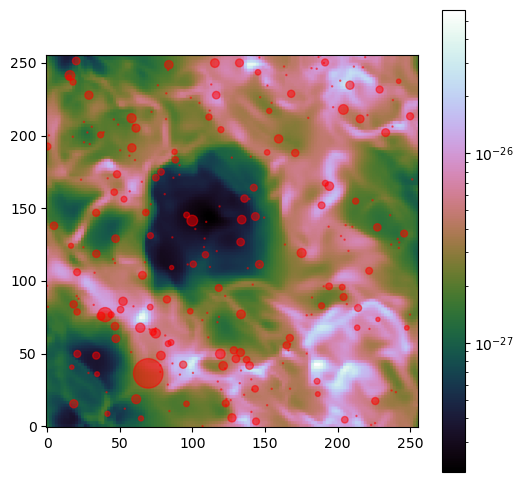

In [48]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(6, 6))
plot_data = np.mean((gas_density['rho'].data).transpose(2, 1, 0), axis=-1).transpose() * density_cf
im = ax.imshow(plot_data, cmap='cubehelix', origin='lower', norm=LogNorm(vmin=plot_data.min(), vmax=plot_data.max()))
plt.scatter(np.array(positions_stars)[:, 0]/4. + 128., np.array(positions_stars)[:, 1]/4. + 128., s=mass_stars*1e-4, c='red', alpha=0.5)
plt.colorbar(im, ax=ax)
plt.show()

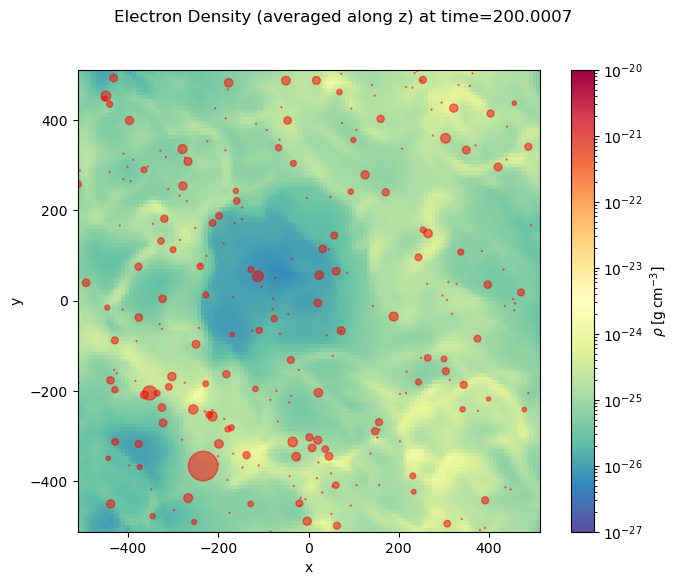

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
gas_density['rho'].mean(dim='z').plot.imshow(ax=ax, **gas_density.dfi['rho']['imshow_args'])
ax.scatter(np.array(positions_stars)[:, 0], np.array(positions_stars)[:, 1], s=mass_stars * 1e-4, c='red', alpha=0.5)
ax.set_aspect('equal')
plt.suptitle(f'Electron Density (averaged along z) at time={electron_density.time}')
plt.show()

In [24]:
output_file = f"{output_dir}Gas_Prova.hdf5"

with h5py.File(output_file, "w") as f:
    dataset = f.create_dataset("gas_data", shape=(Nx[0] * Nx[1] * Nx[2], 12), dtype="f4")
    
    dataset.attrs["header"] = """
    # Gas_Prova.hdf5: import file for cell media -- electrons
    # Column 1: xmin (pc)
    # Column 2: ymin (pc)
    # Column 3: zmin (pc)
    # Column 4: xmax (pc)
    # Column 5: ymax (pc)
    # Column 6: zmax (pc)
    # Column 7: mass density (Msun/pc3)
    # Column 8: metallicity (1)
    # Column 9: temperature (K)
    # Column 10: velocity vx (km/s)
    # Column 11: velocity vy (km/s)
    # Column 12: velocity vz (km/s)
    """

    index = 0
    
    for i in range(Nx[0]):
        for j in range(Nx[1]):
            for k in range(Nx[2]):
                xmin_val = xmin[i]
                ymin_val = ymin[j]
                zmin_val = zmin[k]
                xmax_val = xmax[i]
                ymax_val = ymax[j]
                zmax_val = zmax[k]

                temperature_val = (temperature['T'].data)[k, j, i]
                gas_density_val = (gas_density['rho'].data)[k, j, i] * density_cf
                metallicity_val = (metallicity_gas['specific_scalar[1]'].data)[k, j, i] * solar_metallicity

                vx_val = (velocities_x['vx'].data)[k, j, i]
                vy_val = (velocities_y['vy'].data)[k, j, i]
                vz_val = (velocities_z['vz'].data)[k, j, i]

                #num_electrons_val = electron_density_val * volume

                dataset[index] = [
                    xmin_val, ymin_val, zmin_val,
                    xmax_val, ymax_val, zmax_val,
                    gas_density_val, metallicity_val, temperature_val,
                    vx_val, vy_val, vz_val
                ]
                index += 1

KeyboardInterrupt: 

In [73]:
## Dust

In [ ]:
output_file = f"{output_dir}Dust_Prova.hdf5"

with h5py.File(output_file, "w") as f:
    dataset = f.create_dataset("dust_data", shape=(Nx[0] * Nx[1] * Nx[2], 12), dtype="f4")
    
    dataset.attrs["header"] = """
    # Dust_Prova.hdf5: import file for cell media -- dust
    # Column 1: xmin (pc)
    # Column 2: ymin (pc)
    # Column 3: zmin (pc)
    # Column 4: xmax (pc)
    # Column 5: ymax (pc)
    # Column 6: zmax (pc)
    # Column 7: gas mass (Msun/pc3)
    # Column 8: metallicity (1)
    # Column 9: temperature (K)
    # Column 10: velocity vx (km/s)
    # Column 11: velocity vy (km/s)
    # Column 12: velocity vz (km/s)
    """

    index = 0
    
    for i in range(Nx[0]):
        for j in range(Nx[1]):
            for k in range(Nx[2]):
                xmin_val = xmin[i]
                ymin_val = ymin[j]
                zmin_val = zmin[k]
                xmax_val = xmax[i]
                ymax_val = ymax[j]
                zmax_val = zmax[k]

                gas_density_val = (gas_density['rho'].data)[k, j, i] * density_cf
                metallicity_val = (metallicity_gas['specific_scalar[1]'].data)[k, j, i] * solar_metallicity
                temperature_val = (temperature_gas['T'].data)[k, j, i]

                vx_val = (velocities_gas['vx'].data)[k, j, i]
                vy_val = (velocities_gas['vy'].data)[k, j, i]
                vz_val = (velocities_gas['vz'].data)[k, j, i]

                #mass_val = density_val * volume
                
                dataset[index] = [
                    xmin_val, ymin_val, zmin_val,
                    xmax_val, ymax_val, zmax_val,
                    gas_density_val, metallicity_val, temperature_val,
                    vx_val, vy_val, vz_val
                ]
                index += 1

In [15]:
# Selected stars & gas (RIDOTTO)

In [16]:
# (-512 < x3 < 512 /// 640 < Nx[3] < 896) NO

In [17]:
# (-256 < x3 < 256 /// 704 < Nx[3] < 832) YES

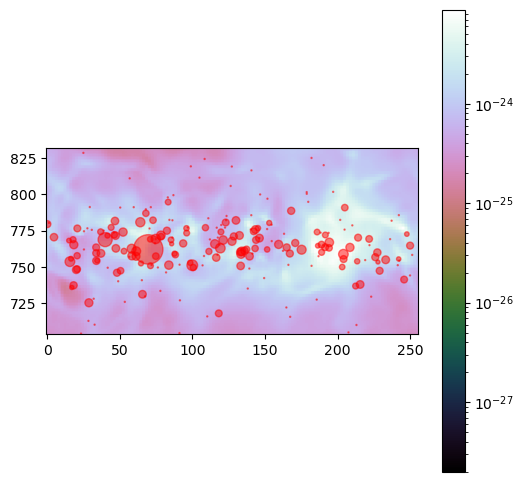

226 stars in the area VS total of 269


In [41]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_data = np.mean((gas_density['rho'].data).transpose(2, 1, 0), axis=1).transpose()
im = ax.imshow(plot_data, cmap='cubehelix', origin='lower', norm=LogNorm(vmin=plot_data.min(), vmax=plot_data.max()))
plt.scatter(np.array(positions_stars)[:, 0]/4. + 128., np.array(positions_stars)[:, 2]/4. + 768., s=mass_stars*1e-4, c='red', alpha=0.5)
plt.colorbar(im, ax=ax)
ax.set_ylim(704, 832)
plt.show()

counter = 0
for i in np.arange(len(positions_stars["x3"])):
        if (704 * 4 - 3072 <= positions_stars["x3"][i]):
            if (positions_stars["x3"][i] < 832 * 4 - 3072):
                counter = counter + 1
print(str(counter) + ' stars in the area VS total of ' + str(len(positions_stars["x3"])))

In [88]:
output_file = f"{output_dir}Stars_Prova_Ridotto.hdf5"

with h5py.File(output_file, "w") as f:
    dataset = f.create_dataset("stars_data", shape=(counter, 10), dtype="f4")
    
    dataset.attrs["header"] = """
    # Stars_Prova_Ridotto.hdf5: import file for particle source
    # Column 1: position x (pc)
    # Column 2: position y (pc)
    # Column 3: position z (pc)
    # Column 4: smoothing length (pc)
    # Column 5: velocity vx (km/s)
    # Column 6: velocity vy (km/s)
    # Column 7: velocity vz (km/s)
    # Column 8: mass (Msun)
    # Column 9: metallicity (1)
    # Column 10: age (Gyr)
    """

    index = 0
    
    for i in range(counter):
        if (704 * 4 - 3072 <= positions_stars["x3"][i]):
            if (positions_stars["x3"][i] < 832 * 4 - 3072):
                position_x = positions_stars["x1"][i]
                position_y = positions_stars["x2"][i]
                position_z = positions_stars["x3"][i]
                smoothing_length = smoothing_length_stars[i]
                velocity_x = velocities_stars["v1"][i]
                velocity_y = velocities_stars["v2"][i]
                velocity_z = velocities_stars["v3"][i]
                mass = mass_stars[i] * mass_cf
                metallicity = metallicity_stars[i] * solar_metallicity
                age = age_stars[i] * time_cf

                dataset[index] = [
                    position_x, position_y, position_z,
                    smoothing_length, velocity_x, velocity_y, velocity_z,
                    mass, metallicity, age
                ]
                index += 1

In [42]:
output_file = f"{output_dir}Gas_Prova_Ridotto.hdf5"

with h5py.File(output_file, "w") as f:
    dataset = f.create_dataset("gas_data", shape=(Nx[0] * Nx[1] * 128, 12), dtype="f8")
    
    dataset.attrs["header"] = """
    # Gas_Prova_Ridotto.hdf5: import file for cell media -- electrons
    # Column 1: xmin (pc)
    # Column 2: ymin (pc)
    # Column 3: zmin (pc)
    # Column 4: xmax (pc)
    # Column 5: ymax (pc)
    # Column 6: zmax (pc)
    # Column 7: mass density (Msun/pc3)
    # Column 8: metallicity (1)
    # Column 9: temperature (K)
    # Column 10: velocity vx (km/s)
    # Column 11: velocity vy (km/s)
    # Column 12: velocity vz (km/s)
    """
    
    index = 0
    
    for i in range(Nx[0]):
        for j in range(Nx[1]):
            for k in range(704, 832):
                xmin_val = xmin[i]
                ymin_val = ymin[j]
                zmin_val = zmin[k]
                xmax_val = xmax[i]
                ymax_val = ymax[j]
                zmax_val = zmax[k]

                temperature_val = (temperature['T'].data)[k, j, i]
                gas_density_val = (gas_density['rho'].data)[k, j, i] * density_cf
                metallicity_val = (metallicity_gas['specific_scalar[1]'].data)[k, j, i] * solar_metallicity

                vx_val = (velocities_x['vx'].data)[k, j, i]
                vy_val = (velocities_y['vy'].data)[k, j, i]
                vz_val = (velocities_z['vz'].data)[k, j, i]

                #num_electrons_val = electron_density_val * volume

                dataset[index] = [
                    xmin_val, ymin_val, zmin_val,
                    xmax_val, ymax_val, zmax_val,
                    gas_density_val, metallicity_val, temperature_val,
                    vx_val, vy_val, vz_val
                ]
                index += 1

In [17]:
# Trying to read them (RIDOTTO)

In [18]:
stars_path = "/export/home/extragal/francesco.chititegli/TIGRESS_1/Stars_Prova_Ridotto.hdf5"
stars_dataset = 'stars_data'

gas_path = "/export/home/extragal/francesco.chititegli/TIGRESS_1/Gas_Prova_Ridotto.hdf5"
gas_dataset = 'gas_data'

def inspect_hdf5(file_path, dataset_name, preview_rows=3):
    try:
        with h5py.File(file_path, "r") as f:
            print("Keys in the file:", list(f.keys()))

            if dataset_name:
                if dataset_name in f:
                    dataset = f[dataset_name]
                    print(f"\nInspecting dataset '{dataset_name}':")
                    print(f"  Shape: {dataset.shape}")
                    print(f"  Dtype: {dataset.dtype}")
                    print(f"  Preview (first {preview_rows} rows):\n", dataset[:preview_rows])
                else:
                    print(f"\nDataset '{dataset_name}' not found in the file.")
            else:
                print("\nNo dataset name provided. Use one of the keys above to inspect specific data.")
    except Exception as e:
        print(f"Error opening or inspecting HDF5 file: {e}")
    print('\n')

def inspect_hdf5_attributes(file_path):
    try:
        with h5py.File(file_path, "r") as f:
            print("\nFile-level attributes:")
            for attr_name, attr_value in f.attrs.items():
                print(f"{attr_name}: {attr_value}")

            print("\nDataset-level attributes:")
            for dataset_name in f.keys():
                dataset = f[dataset_name]
                print(f"\nAttributes of dataset '{dataset_name}':")
                for attr_name, attr_value in dataset.attrs.items():
                    print(f"  {attr_name}: {attr_value}")
    except Exception as e:
        print(f"Error inspecting HDF5 file: {e}")

inspect_hdf5(stars_path, stars_dataset)
inspect_hdf5(gas_path, gas_dataset)
inspect_hdf5_attributes(stars_path)
inspect_hdf5_attributes(gas_path)

Keys in the file: ['stars_data']

Inspecting dataset 'stars_data':
  Shape: (226, 10)
  Dtype: float32
  Preview (first 3 rows):
 [[-1.2829146e+02 -4.5033002e+02  3.4969208e+01  1.0000000e-01
  -3.6735613e+00 -4.9716172e-01  2.5522664e+00  5.2527544e+03
   1.2355671e-03  2.2620997e-04]
 [-4.5163806e+02  4.4813647e+02  1.2510514e+00  1.0000000e-01
  -1.9851127e+00  1.3861067e+01 -5.6106037e-01  3.9573005e+03
   1.2548170e-03  1.9583416e-04]
 [-3.5215149e+02 -2.0459894e+02  3.7800314e+00  1.0000000e-01
   5.8173962e+00  9.6928921e+00 -1.0357850e+00  3.5661203e+04
   1.8618716e-03  2.1432289e-04]]


Keys in the file: ['gas_data']

Inspecting dataset 'gas_data':
  Shape: (8388608, 12)
  Dtype: float64
  Preview (first 3 rows):
 [[-5.12000000e+02 -5.12000000e+02 -2.56000000e+02 -5.08000000e+02
  -5.08000000e+02 -2.52000000e+02  2.53585555e-27  1.63196420e-04
   7.34762646e+03  1.36353769e+01  9.58051300e+00 -6.95910215e-01]
 [-5.12000000e+02 -5.12000000e+02 -2.52000000e+02 -5.08000000e+02
 

In [19]:
def load_hdf5(file_path, dataset_name, num_columns):
    try:
        with h5py.File(file_path, "r") as f:
            if dataset_name in f:
                dataset = f[dataset_name]
                
                print(f"Dataset '{dataset_name}' loaded successfully.")
                print(f"Shape: {dataset.shape}")
                print(f"Dtype: {dataset.dtype}")
                
                total_elements = dataset.shape[0] * dataset.shape[1]
                if total_elements % num_columns != 0:
                    raise ValueError(f"The dataset cannot be reshaped into {num_columns} columns. Total elements {total_elements} are not divisible by {num_columns}.")

                reshaped_data = dataset[:].reshape(-1, num_columns)

                print(f"Reshaped data shape: {reshaped_data.shape}")
                return reshaped_data
            else:
                print(f"Dataset '{dataset_name}' not found in the file.")
                return None
    except Exception as e:
        print(f"Error loading and parsing dataset: {e}")
        return None

stars_open = load_hdf5(stars_path, stars_dataset, 10)
gas_open = load_hdf5(gas_path, gas_dataset, 12)

Dataset 'stars_data' loaded successfully.
Shape: (226, 10)
Dtype: float32
Reshaped data shape: (226, 10)
Dataset 'gas_data' loaded successfully.
Shape: (8388608, 12)
Dtype: float64
Reshaped data shape: (8388608, 12)


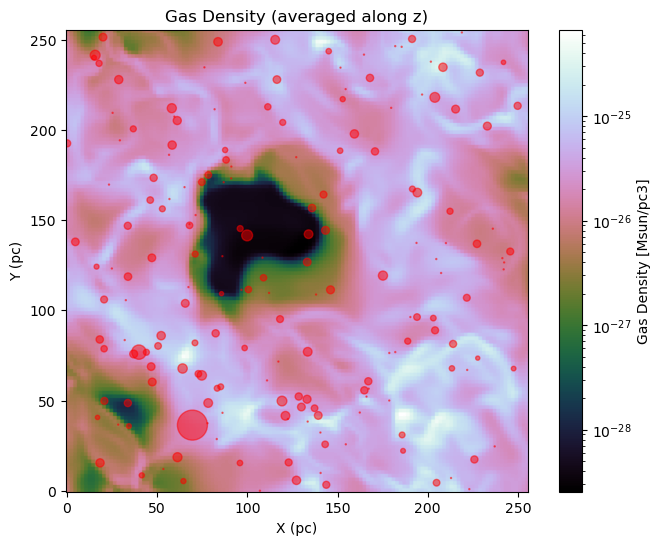

In [20]:
with h5py.File(f"{output_dir}Stars_Prova_Ridotto.hdf5", "r") as f:
    dataset = f["stars_data"]
    positions_x_prova = dataset[:][:, 0]
    positions_y_prova = dataset[:][:, 1]
    masses_prova = dataset[:][:, 7]

with h5py.File(f"{output_dir}Gas_Prova_Ridotto.hdf5", "r") as f:
    dataset = f["gas_data"]
    gas_density_prova = dataset[:][:, 6].reshape(256, 256, 128)
    averaged_gas_density = np.mean(gas_density_prova, axis=2).transpose()

plt.figure(figsize=(8, 6))
plt.imshow(averaged_gas_density, cmap='cubehelix', origin='lower', norm=LogNorm(vmin=averaged_gas_density.min(), vmax=averaged_gas_density.max()))
plt.colorbar(label="Gas Density [Msun/pc3]")
plt.scatter(np.array(positions_x_prova)/4. + 128., np.array(positions_y_prova)/4. + 128., s=masses_prova*0.003, c='red', alpha=0.5)
plt.title("Gas Density (averaged along z)")
plt.xlabel("X (pc)")
plt.ylabel("Y (pc)")
plt.show()

In [61]:
(gas_density['rho'].data * density_cf).min()

1.6811518e-30

In [34]:
gas_density_prova.min()

7.048509206815673e-30

In [60]:
gas_megarray[:,6].min()

7.048509206815673e-30

In [53]:
# RIDOTTO (but in txt, looks like SKIRT cannot process hdf5)

In [29]:
def convert_hdf5_to_txt(hdf5_file_path, dataset_name, output_txt_path):
    try:
        with h5py.File(hdf5_file_path, "r") as f:
            dataset = f[dataset_name]
            
            data = dataset[:]
            
            header = dataset.attrs.get("header", "").strip()
            
        with open(output_txt_path, "w") as txt_file:
            if header:
                txt_file.write(header + "\n")
            
            np.savetxt(txt_file, data, fmt="%g")
        
        print(f"Dataset '{dataset_name}' from '{hdf5_file_path}' successfully saved as '{output_txt_path}'.")

    except Exception as e:
        print(f"Error: {e}")

In [30]:
convert_hdf5_to_txt(hdf5_file_path=f"{output_dir}Stars_Prova_Ridotto.hdf5", dataset_name="stars_data", output_txt_path=f"{output_dir}Stars_Prova_Ridotto.txt")

Dataset 'stars_data' from '/export/home/extragal/francesco.chititegli/TIGRESS_1/Stars_Prova_Ridotto.hdf5' successfully saved as '/export/home/extragal/francesco.chititegli/TIGRESS_1/Stars_Prova_Ridotto.txt'.


In [31]:
convert_hdf5_to_txt(hdf5_file_path=f"{output_dir}Gas_Prova_Ridotto.hdf5", dataset_name="gas_data", output_txt_path=f"{output_dir}Gas_Prova_Ridotto.txt")

Dataset 'gas_data' from '/export/home/extragal/francesco.chititegli/TIGRESS_1/Gas_Prova_Ridotto.hdf5' successfully saved as '/export/home/extragal/francesco.chititegli/TIGRESS_1/Gas_Prova_Ridotto.txt'.


In [ ]:
#

In [ ]:
# BEST FUNCTION TO DIRECTLY WRITE THE DATASETS IN TXT

In [ ]:
#

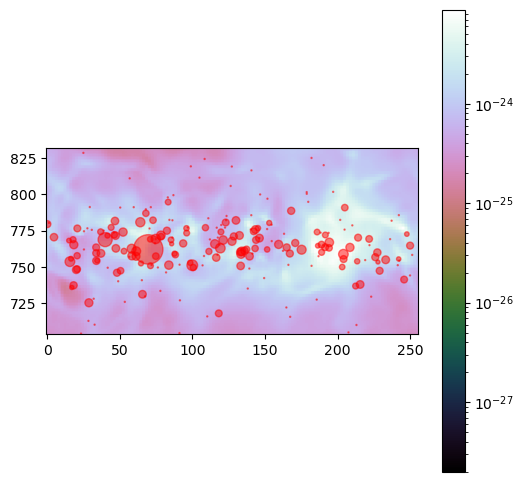

226 stars in the area VS total of 269


In [35]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_data = np.mean((gas_density['rho'].data).transpose(2, 1, 0), axis=1).transpose()
im = ax.imshow(plot_data, cmap='cubehelix', origin='lower', norm=LogNorm(vmin=plot_data.min(), vmax=plot_data.max()))
plt.scatter(np.array(positions_stars)[:, 0]/4. + 128., np.array(positions_stars)[:, 2]/4. + 768., s=mass_stars*1e-4, c='red', alpha=0.5)
plt.colorbar(im, ax=ax)
ax.set_ylim(704, 832)
plt.show()

counter = 0
for i in np.arange(len(positions_stars["x3"])):
        if (704 * 4 - 3072 <= positions_stars["x3"][i]):
            if (positions_stars["x3"][i] < 832 * 4 - 3072):
                counter = counter + 1
print(str(counter) + ' stars in the area VS total of ' + str(len(positions_stars["x3"])))

In [49]:
stars_megarray = []
for i in range(len(positions_stars["x3"])):
    if (704 * 4 - 3072 <= positions_stars["x3"][i]):
        if (positions_stars["x3"][i] < 832 * 4 - 3072):
            position_x = positions_stars["x1"][i]
            position_y = positions_stars["x2"][i]
            position_z = positions_stars["x3"][i]
            smoothing_length = smoothing_length_stars[i]
            velocity_x = velocities_stars["v1"][i]
            velocity_y = velocities_stars["v2"][i]
            velocity_z = velocities_stars["v3"][i]
            mass = mass_stars[i] * mass_cf
            metallicity = metallicity_stars[i] * solar_metallicity
            age = age_stars[i] * time_cf

            stars_megarray.append([position_x, position_y, position_z, smoothing_length, velocity_x, velocity_y, velocity_z, mass, metallicity, age])
stars_megarray = np.array(stars_megarray)

In [54]:
gas_megarray = []
for i in range(Nx[0]):
    for j in range(Nx[1]):
        for k in range(704, 832):
            xmin_val = xmin[i]
            ymin_val = ymin[j]
            zmin_val = zmin[k]
            xmax_val = xmax[i]
            ymax_val = ymax[j]
            zmax_val = zmax[k]

            temperature_val = (temperature['T'].data)[k, j, i]
            gas_density_val = (gas_density['rho'].data)[k, j, i] * density_cf
            metallicity_val = (metallicity_gas['specific_scalar[1]'].data)[k, j, i] * solar_metallicity

            vx_val = (velocities_x['vx'].data)[k, j, i]
            vy_val = (velocities_y['vy'].data)[k, j, i]
            vz_val = (velocities_z['vz'].data)[k, j, i]

            gas_megarray.append([xmin_val, ymin_val, zmin_val, xmax_val, ymax_val, zmax_val,gas_density_val, metallicity_val, temperature_val, vx_val, vy_val, vz_val])
gas_megarray = np.array(gas_megarray)

In [58]:
header = """# Stars_Prova_Ridotto.txt: import file for particle source 
# Column 1: position x (pc)
# Column 2: position y (pc)
# Column 3: position z (pc)
# Column 4: smoothing length (pc)
# Column 5: velocity vx (km/s)
# Column 6: velocity vy (km/s)
# Column 7: velocity vz (km/s)
# Column 8: mass (Msun)
# Column 9: metallicity (1)
# Column 10: age (Gyr)
#
"""

with open(f"{output_dir}Stars_Prova_Ridotto.txt", "w") as txt_file:
    txt_file.write(header)
    np.savetxt(txt_file, stars_megarray, fmt="%g")

In [59]:
header = """# Gas_Prova_Ridotto.txt: import file for cell media -- gas
# Column 1: xmin (pc)
# Column 2: ymin (pc)
# Column 3: zmin (pc)
# Column 4: xmax (pc)
# Column 5: ymax (pc)
# Column 6: zmax (pc)
# Column 7: mass density (Msun/pc3)
# Column 8: metallicity (1)
# Column 9: temperature (K)
# Column 10: velocity vx (km/s)
# Column 11: velocity vy (km/s)
# Column 12: velocity vz (km/s)
#
"""

with open(f"{output_dir}Gas_Prova_Ridotto.txt", "w") as txt_file:
    txt_file.write(header)
    np.savetxt(txt_file, gas_megarray, fmt="%g")